<a href="https://colab.research.google.com/github/msc-acse/acse-8-miniproject-sigmoid/blob/master/KMNIST_SDeepAlex_old_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Working Environment

## Sync to GitHub

In [1]:
from getpass import getpass
import os

#checking
user = getpass('github user')
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-sigmoid.git sigmoid

github user··········
github password··········
Cloning into 'sigmoid'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 168 (delta 10), reused 9 (delta 3), pack-reused 135
Receiving objects: 100% (168/168), 25.20 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (56/56), done.


## Sync to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Install Dependencies and CUDA

In [3]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import time
import random
import copy

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 491kB 17.4MB/s 
     |████████████████████████████████| 215kB 46.3MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Cuda installed! Running on GPU!


## Import Tools to Perform Supervised Learning on KMNIST

In [0]:
%load_ext autoreload
%autoreload 2
from sigmoid.KMNISTLearning import *

# Define Model Classes
Each model class should include a `forward` method.

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
class mLeNet5(nn.Module):
  def __init__(self):
     super(mLeNet5, self).__init__()
     self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
     self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
     self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c5 = nn.Linear(16*5*5, 1150)
     self.f6 = nn.Linear(1150, 256)
     self.output = nn.Linear(256, 10)
     self.act = nn.ReLU()
     self.dp = nn.Dropout(0.5)

  def forward(self, x):
     x = self.act(self.c1(x))
     x = self.act(self.s2(x))
     x = self.act(self.c3(x))
     x = self.act(self.s4(x))
     x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
     x = self.act(self.c5(x))
     x = self.dp(x)
     x = self.act(self.f6(x))
     x = self.dp(x)
     return self.output(x)

In [0]:
class AlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(AlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        if train:
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes),
            )
            
        else:
            self.classifier = nn.Sequential(
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class mAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(mAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class DeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(DeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class SDeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(SDeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=5, padding=2),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Import Data as `torch.Tensor`

In [10]:
!pwd

/content


In [6]:
# Import Data
path="sigmoid/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

#test_labels = np.load("/gdrive/My Drive/data/kmnist-test-labels.npz")

# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

# Size Check
print("Train Data:", X.size())
print("Test Data:", X_test.size())
print("Train Labels:", y.size())

Train Data: torch.Size([60000, 28, 28])
Test Data: torch.Size([10000, 28, 28])
Train Labels: torch.Size([60000])


# Model Training and Saving

## SDeepAlex with old Augmentation full set

In [0]:
# DeepAlexNet with augmentation
# Hyperparameters

lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 50

model = SDeepAlexNetMod(num_classes=10)
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_function = nn.CrossEntropyLoss()

learning_SDeep_full_old = SupervisedLearning(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device=device,
                 transform=True, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = False,
                 patience = 5,
                 tol = 0.001)

t = learning_SDeep_full_old.train_wrapper(train_full=True)
print(t)

# Load model and perform predictions on test set
SDeep_model_full_old_aug = learning_SDeep_full_old.model
path = F"/content/gdrive/My Drive/Models/"
model_name="SDeep_model_full_old_aug"
#model_alex_aug_full = torch.load(path + model_name + '.pth')
model_save(SDeep_model_full_old_aug, model_name, path, 0000)
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

y_preds_full, sub_full = evaluate(X_test/255, SDeep_model_full_old_aug, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"SDeep_model_full_old_aug.csv")

print(y_preds_full)

test_labels = np.load("./gdrive/My Drive/data/kmnist-test-labels.npz")
test_label_array = test_labels['arr_0']
print("Accuracy: ", 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array))

In [8]:
# Load model and perform predictions on test set
SDeep_model_full_old_aug = learning_SDeep_full_old.model
path = F"/content/gdrive/My Drive/Models/"
model_name="SDeep_model_full_old_aug"
#model_alex_aug_full = torch.load(path + model_name + '.pth')
model_save(SDeep_model_full_old_aug, model_name, path, 0000)
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

y_preds_full, sub_full = evaluate(X_test/255, SDeep_model_full_old_aug, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"SDeep_model_full_old_aug.csv")

print(y_preds_full)

test_labels = np.load("./gdrive/My Drive/data/kmnist-test-labels.npz")
test_label_array = test_labels['arr_0']
accuracy = 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array)
print("Accuracy: ", 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array))

Saving model under: /content/gdrive/My Drive/Models/SDeep_model_full_old_aug_.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SDeepAlexNetMod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[2 9 3 ... 9 4 6]
Accuracy:  0.9795


NameError: ignored

In [10]:
full_save(path, model_name, SDeep_model_full_old_aug, optimiser, 
          loss_function, 0.001, learning_SDeep_full_old.logs["_i"], lr, 
          momentum, 0, 3, True, learning_SDeep_full_old.logs["val_accuracy"], 
          learning_SDeep_full_old.logs["val_log loss"], 360, test_acc=accuracy)

Saving model under: /content/gdrive/My Drive/Models/SDeep_model_full_old_aug_0.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SDeepAlexNetMod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


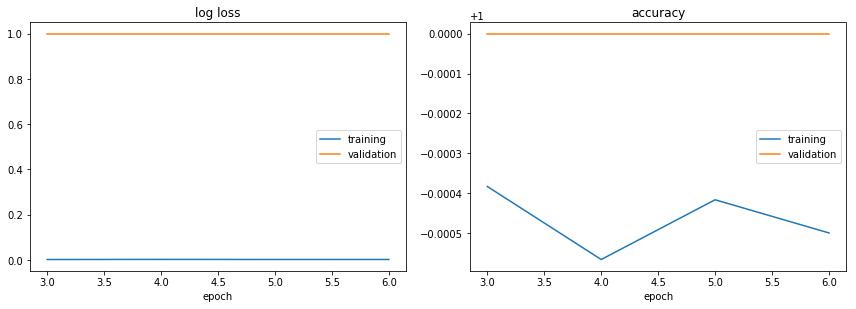

log loss:
training   (min:    0.001, max:    0.002, cur:    0.002)
validation (min:    1.000, max:    1.000, cur:    1.000)

accuracy:
training   (min:    0.999, max:    1.000, cur:    1.000)
validation (min:    1.000, max:    1.000, cur:    1.000)


KeyboardInterrupt: ignored

In [11]:
learning_SDeep_full_old.train_wrapper(train_full=True)


# Load model and perform predictions on test set
SDeep_model_full_old_aug_continue = learning_SDeep_full_old.model
path = F"/content/gdrive/My Drive/Models/"
model_name="SDeep_model_full_old_aug_continue"
#model_alex_aug_full = torch.load(path + model_name + '.pth')
model_save(SDeep_model_full_old_aug_continue, model_name, path, 0000)
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

y_preds_full, sub_full = evaluate(X_test/255, SDeep_model_full_old_aug_continue, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"SDeep_model_full_old_aug_continue.csv")

print(y_preds_full)

test_labels = np.load("./gdrive/My Drive/data/kmnist-test-labels.npz")
test_label_array = test_labels['arr_0']
accuracy = 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array)
print("Accuracy: ", 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array))

In [12]:
# Load model and perform predictions on test set
SDeep_model_full_old_aug_continue = learning_SDeep_full_old.model
path = F"/content/gdrive/My Drive/Models/"
model_name="SDeep_model_full_old_aug_continue"
#model_save(SDeep_model_full_old_aug_continue, model_name, path, 0000)

full_save(path, model_name, SDeep_model_full_old_aug, optimiser, 
          loss_function, 0.001, learning_SDeep_full_old.logs["_i"], lr, 
          momentum, 0, 3, True, learning_SDeep_full_old.logs["val_accuracy"], 
          learning_SDeep_full_old.logs["val_log loss"], 360, test_acc=accuracy)



norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

y_preds_full, sub_full = evaluate(X_test/255, SDeep_model_full_old_aug_continue, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"SDeep_model_full_old_aug_continue.csv")

print(y_preds_full)

test_labels = np.load("./gdrive/My Drive/data/kmnist-test-labels.npz")
test_label_array = test_labels['arr_0']
accuracy = 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array)
print("Accuracy: ", 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array))

Saving model under: /content/gdrive/My Drive/Models/SDeep_model_full_old_aug_continue_0.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SDeepAlexNetMod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[2 9 3 ... 9 4 6]
Accuracy:  0.979


In [26]:
import pandas as pd
df=pd.read_csv("./gdrive/My Drive/Models/deepalex_old_aug_full_9806.csv", sep=',',header=None)
values = df.values[:,1][1:]
current_best = []
for x in values:
  current_best.append(int(x))
 
current_best = np.array(current_best)
#current_best = np.read("./gdrive/My Drive/Models/deepalex_old_aug_full_9806.csv")
print(current_best)

[2 9 3 ... 9 4 2]


In [30]:
y_pre = current_best
len(np.where((y_preds_full - current_best)!= 0)[0])

178

In [31]:
print("Accuracy: ", 1 - len(np.where((current_best - test_label_array)!= 0)[0])/len(test_label_array))

Accuracy:  0.9801


## SDeepAlex with old Augmentation  subset

In [0]:
class SDeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000):
        super(SDeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=5, padding=2),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
# DeepAlexNet with augmentation
# Hyperparameters

lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 50

model = SDeepAlexNetMod(num_classes=10)
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_function = nn.CrossEntropyLoss()

learning_SDeep_subset_old = SupervisedLearning(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device=device,
                 transform=True, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = False,
                 patience = 5,
                 tol = 0.001)

t = learning_SDeep_subset_old.train_wrapper(train_full=True)
print(t)


# Load model and perform predictions on test set
SDeep_model_subset_old_aug = learning_SDeep_subset_old.model
path = F"/content/gdrive/My Drive/Models/"
model_name="SDeep_model_subset_old_aug"
#model_alex_aug_full = torch.load(path + model_name + '.pth')
model_save(SDeep_model_subset_old_aug, model_name, path, 0000)
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

y_preds_full, sub_full = evaluate(X_test/255, SDeep_model_subset_old_aug, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"SDeep_model_subset_old_aug.csv")

print(y_preds_full)


test_labels = np.load("./gdrive/My Drive/data/kmnist-test-labels.npz")
test_label_array = test_labels['arr_0']
print("Accuracy: ", 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array))
